In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import os
from helpers.datasets import *
cm = matplotlib.cm.get_cmap('Greens')

plt.style.use("science.mplstyle")


np.random.seed(8)

from matplotlib.backends.backend_pdf import PdfPages


from sklearn.model_selection import train_test_split


In [2]:
# dataset generation parameters
context_endpoints = (3000, 4000)


bands_dict = {"ob1": [3000, 3200],
              "sb1": [3200, 3400],
              "sr" : [3400, 3600],
              "sb2": [3600, 3800],
              "ob2": [3800, 4000]}

print("Generating datasets...")



df_sim = get_lhco(sim_type = "herwig")
data_sim = select_lhco_features(df_sim, feature_type = 0).to_numpy()

df_dat = get_lhco(sim_type = "pythia")
data_dat = select_lhco_features(df_dat, feature_type = 0).to_numpy()

df_signal = get_lhco(sim_type = "pythia", sm = "signal")
data_signal = select_lhco_features(df_signal, feature_type = 0).to_numpy()


print("SIM shape:", data_sim.shape)
print("DAT shape:", data_dat.shape)
print("SIGNAL shape:", data_signal.shape)



n_features = data_sim.shape[1]


Generating datasets...
events_anomalydetection_herwig_features.h5
events_anomalydetection_v2.features.h5
events_anomalydetection_v2.features.h5
SIM shape: (999986, 6)
DAT shape: (999881, 6)
SIGNAL shape: (99966, 6)


In [3]:
def pull_from_mass_range(dataset, mass_ranges):

        """
        mass_ranges is a list of lists [low_bound, high_bound]
        """

        selected_data = []

        for mass_range in mass_ranges:
            loc = np.where((dataset[:, -1] >= mass_range[0]) & (dataset[:, -1] < mass_range[1]))[0]
            selected_data.append( dataset[loc, :] )
        selected_data = np.concatenate(selected_data)
        np.random.shuffle(selected_data)

        return selected_data
    
    
    
def minmaxscale(data, col_minmax, lower = -3.0, upper = 3.0):
        
       
        minmaxscaled_data = np.zeros(data.shape)
        for col in range(data.shape[1]):

            X_std = (data[:, col] - col_minmax[col][0]) / (col_minmax[col][1] - col_minmax[col][0])
            minmaxscaled_data[:, col] = X_std * (upper - lower) + lower
        
        return minmaxscaled_data
     

def pull_n_signal_events(n, sig_dataset):
    
    selected_sig_indices = np.random.choice(sig_dataset.shape[0], size=n, replace=False)
    selected_sig_events = sig_dataset[selected_sig_indices]
    
    return(selected_sig_events)


In [4]:
herwig_bkg_dict = {}
pythia_bkg_dict = {}
pythia_sig_dict = {}

num_sig_events = {}

for b in bands_dict.keys():
    print(f"Number of events in band {b}:")
    loc = pull_from_mass_range(data_sim, [bands_dict[b]])
    herwig_bkg_dict[b] = loc
    print(f"Herwig bkg: {len(loc)}")
    loc = pull_from_mass_range(data_dat, [bands_dict[b]])
    pythia_bkg_dict[b] = loc
    print(f"Pythia bkg: {len(loc)}")
    loc = pull_from_mass_range(data_signal, [bands_dict[b]])
    pythia_sig_dict[b] = loc
    num_sig_events[b] = len(loc)
    print(f"Pythia sig: {len(loc)}")
          
    print()

num_total_sig_events = sum(list(num_sig_events.values()))

print(num_total_sig_events)

Number of events in band ob1:
Herwig bkg: 105063
Pythia bkg: 105517
Pythia sig: 4682

Number of events in band sb1:
Herwig bkg: 79793
Pythia bkg: 80037
Pythia sig: 18564

Number of events in band sr:
Herwig bkg: 60739
Pythia bkg: 60038
Pythia sig: 49335

Number of events in band sb2:
Herwig bkg: 45021
Pythia bkg: 44525
Pythia sig: 18136

Number of events in band ob2:
Herwig bkg: 33819
Pythia bkg: 33163
Pythia sig: 3215

93932


## Pull from ob1 -> ob2 to visualize and get column rescales

In [5]:
in_range_herwig_bkg = pull_from_mass_range(data_sim, [bands_dict["ob1"], bands_dict["sb1"], bands_dict["sr"], bands_dict["sb2"], bands_dict["ob2"]])
in_range_pythia_bkg = pull_from_mass_range(data_dat, [bands_dict["ob1"], bands_dict["sb1"], bands_dict["sr"], bands_dict["sb2"], bands_dict["ob2"]])
in_range_pythia_sig = pull_from_mass_range(data_signal, [bands_dict["ob1"], bands_dict["sb1"], bands_dict["sr"], bands_dict["sb2"], bands_dict["ob2"]])


# list of (min, max) to preprocess every column
col_minmax = []
for col in range(n_features):
            col_minmax.append([np.min(in_range_herwig_bkg[:, col]), np.max(in_range_herwig_bkg[:, col])])

col_rescales = []
for col in range(n_features):
            col_rescales.append([np.mean(in_range_herwig_bkg[:, col]), np.std(in_range_herwig_bkg[:, col])])


print("SIM shape:", in_range_herwig_bkg.shape)
print("DAT shape:", in_range_pythia_bkg.shape)
print("SIGNAL shape:", in_range_pythia_sig.shape)




SIM shape: (324435, 6)
DAT shape: (323280, 6)
SIGNAL shape: (93932, 6)


### Generate a standard test set and write out

This is the first 20k signal, 20k background events IN THE SR


(20000, 6) (20000, 6)
{'ob1': 4682, 'sb1': 18564, 'sr': 49335, 'sb2': 18136, 'ob2': 3215}


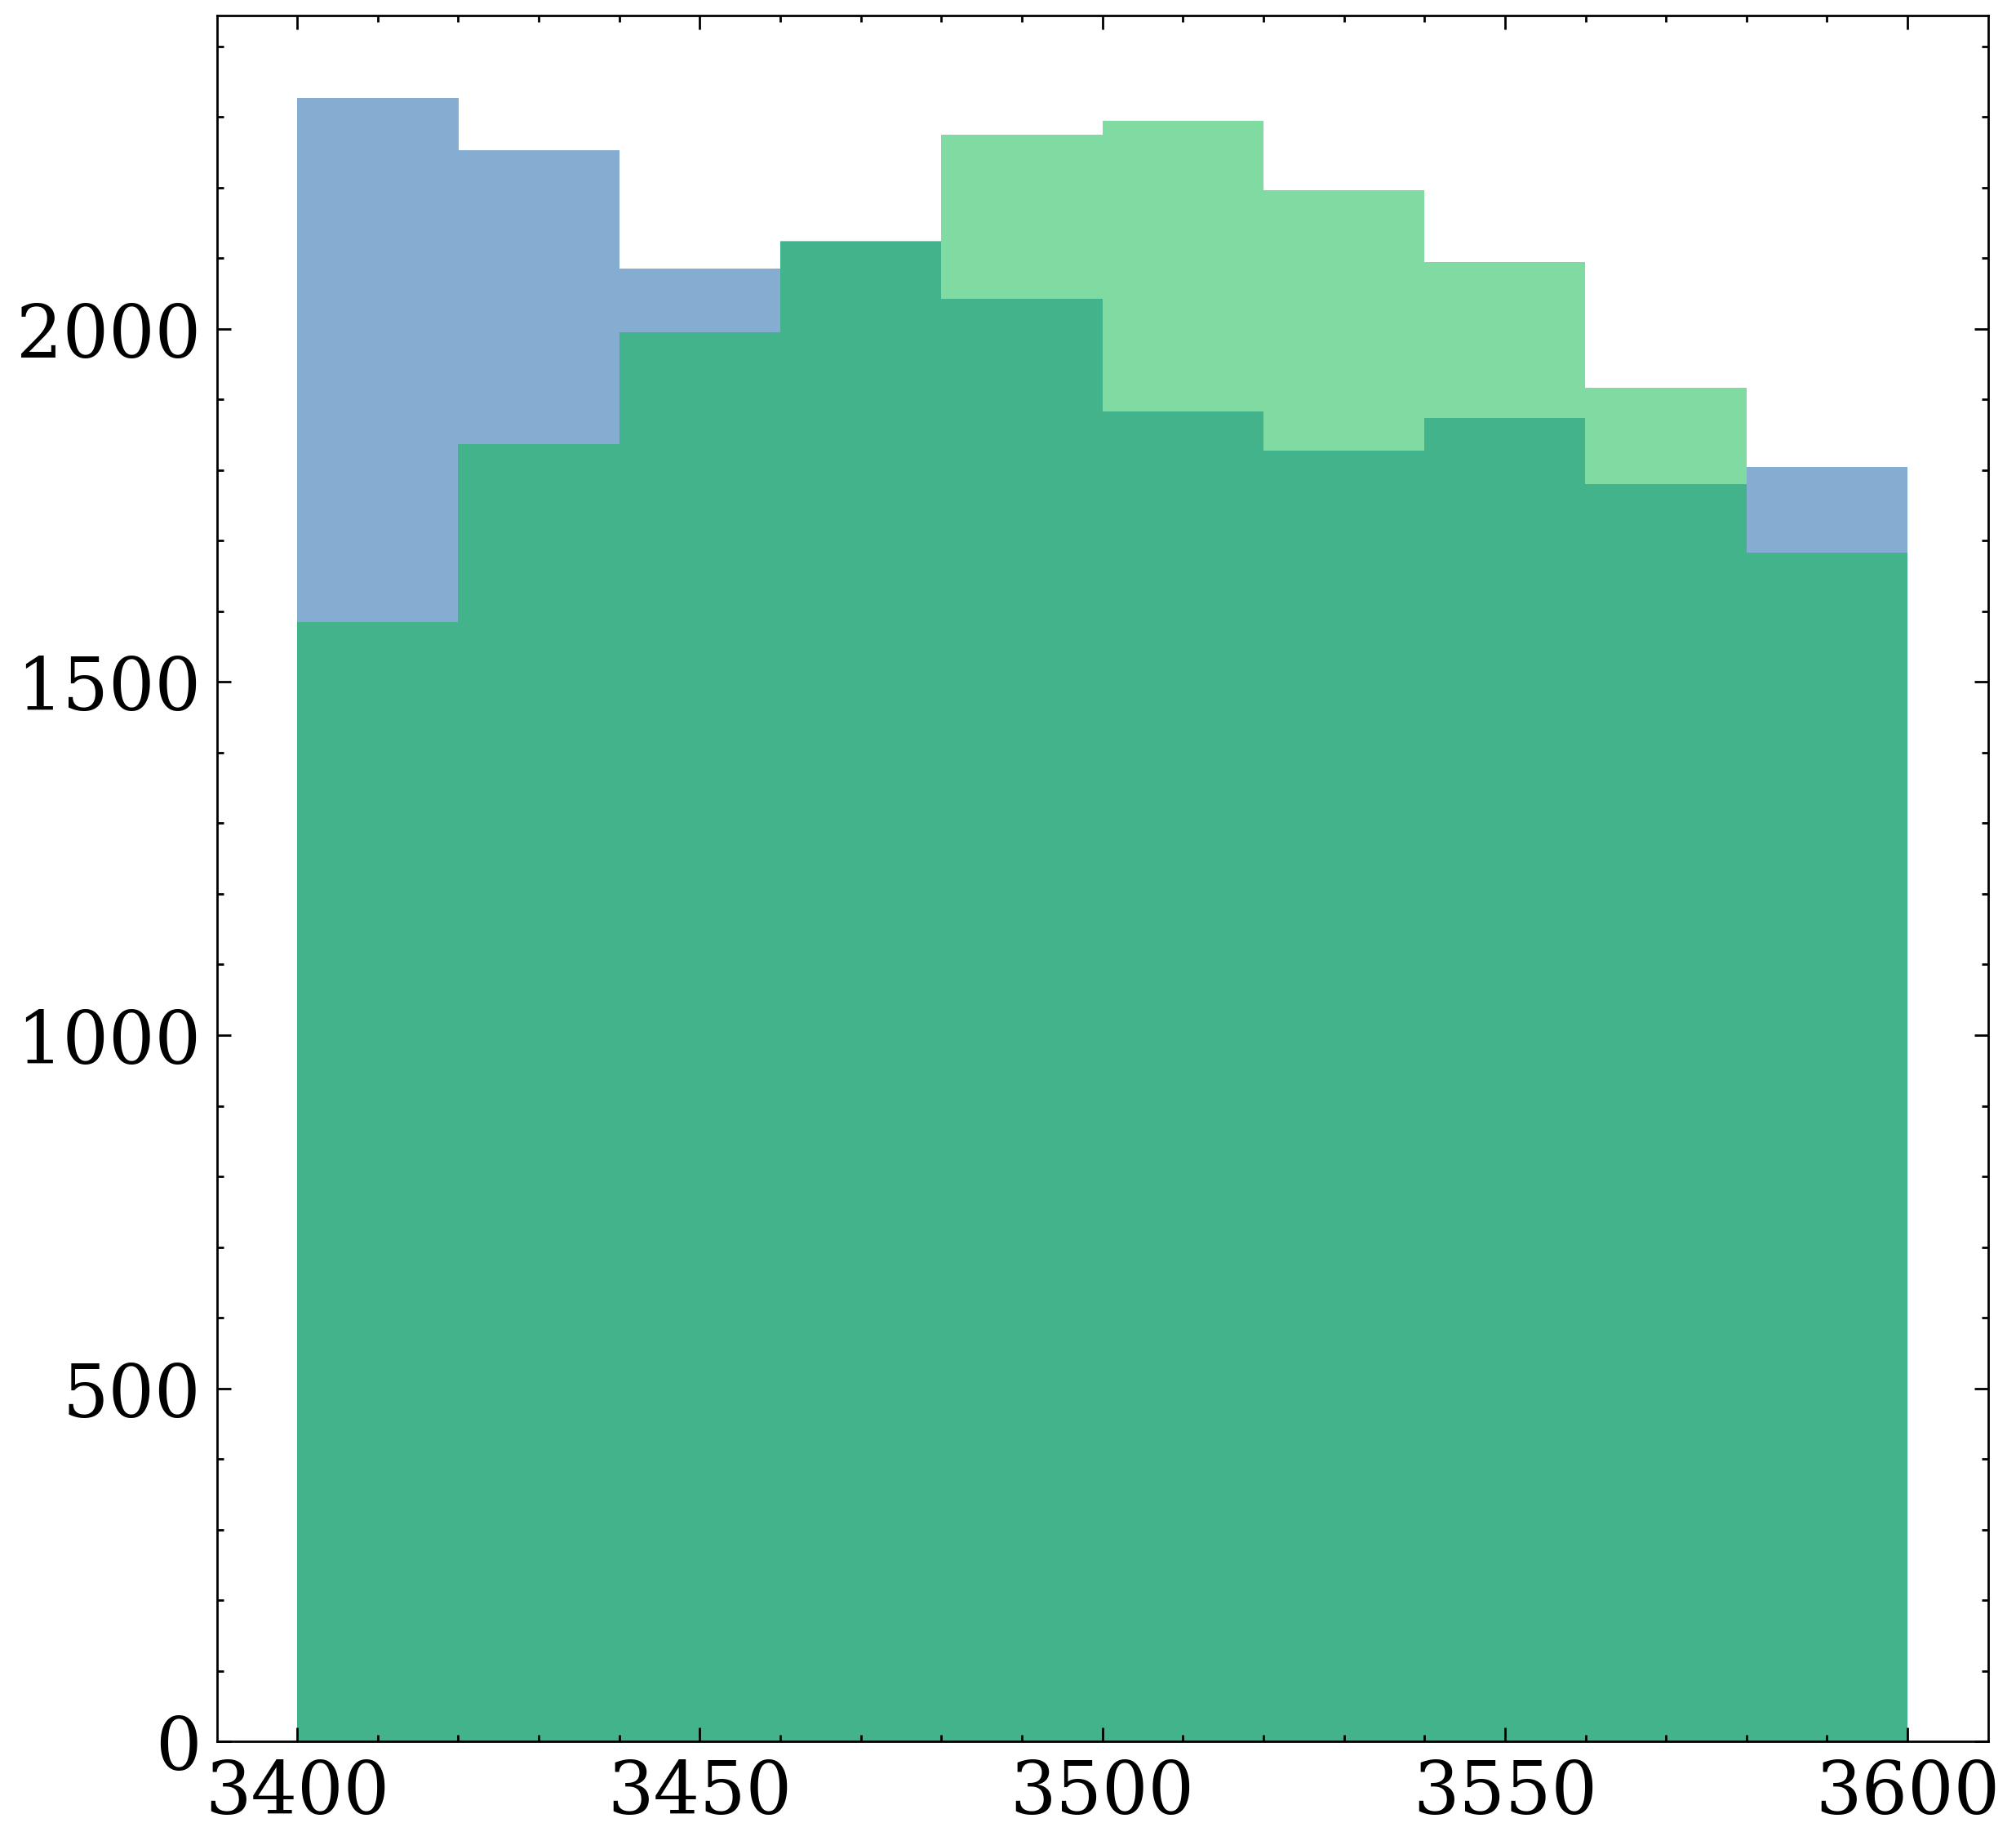

In [6]:
n_sts = 20000

#sts_sim = trial_data_sim[:n_sts]
sts_bkg = pythia_bkg_dict["sr"][:n_sts]
sts_sig = pythia_sig_dict["sr"][:n_sts]

print(sts_bkg.shape, sts_sig.shape)

print(num_sig_events)
plt.figure()
plt.hist(sts_bkg[:,-1], alpha = 0.5)
plt.hist(sts_sig[:,-1], alpha = 0.5)
plt.show()



In [7]:
# directories
curtains_dir = "/global/home/users/rrmastandrea/CURTAINS_SALAD/"

STS_config_string = f"LHCO_STS/"
STS_dir = os.path.join(curtains_dir, STS_config_string, "data")
os.makedirs(STS_dir, exist_ok=True)


np.save(os.path.join(STS_dir, "STS_bkg.npy"), sts_bkg)
np.save(os.path.join(STS_dir, "STS_sig.npy"), sts_sig)
np.save(os.path.join(STS_dir, "col_minmax.npy"), col_minmax)
np.save(os.path.join(STS_dir, "col_rescales.npy"), col_rescales)


### Pull n signal events from the range (ob1 -> ob2)

In [13]:
num_signal_to_inject = 0

# initialize the "data"
pythia_bkg_w_inj = in_range_pythia_bkg


# to get the ratios right: to inject nnum_signal_to_inject events:
    #for each band, inject num_signal_to_inject*num_sig_events[band]/num_total_sig_events
    
for b in bands_dict.keys():
    n_sig_band = int(num_signal_to_inject*num_sig_events[b]/num_total_sig_events)
    if b != "sr":
        selected_signal_band = pull_n_signal_events(n_sig_band, pythia_sig_dict[b])
    else: 
        selected_signal_band = pull_n_signal_events(n_sig_band, pythia_sig_dict[b][n_sts:])
    pythia_bkg_w_inj = np.concatenate((pythia_bkg_w_inj, selected_signal_band))

print(in_range_pythia_bkg.shape)
print(pythia_bkg_w_inj.shape)


np.random.shuffle(pythia_bkg_w_inj)


(323280, 6)
(323280, 6)


## Nice plots of the dataset

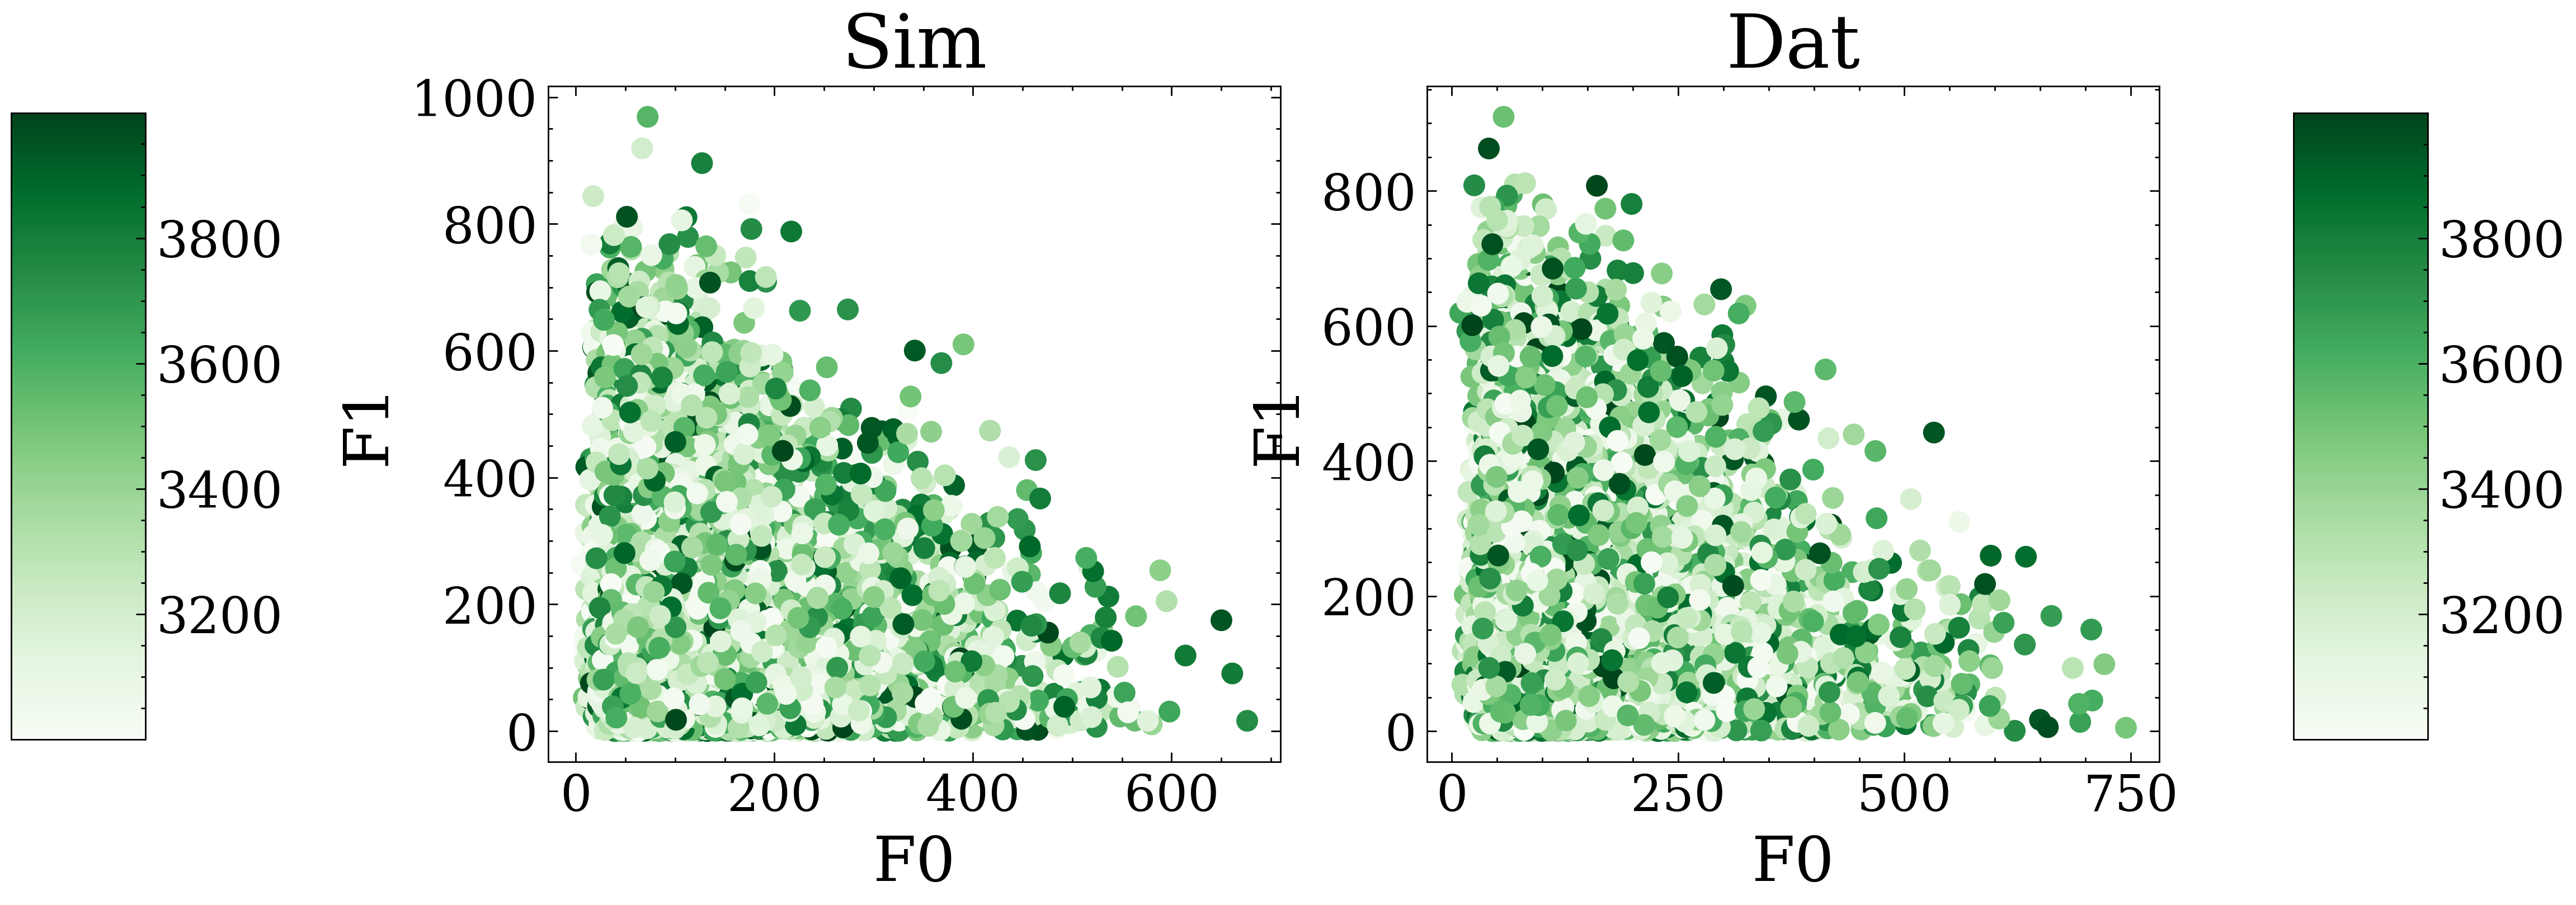

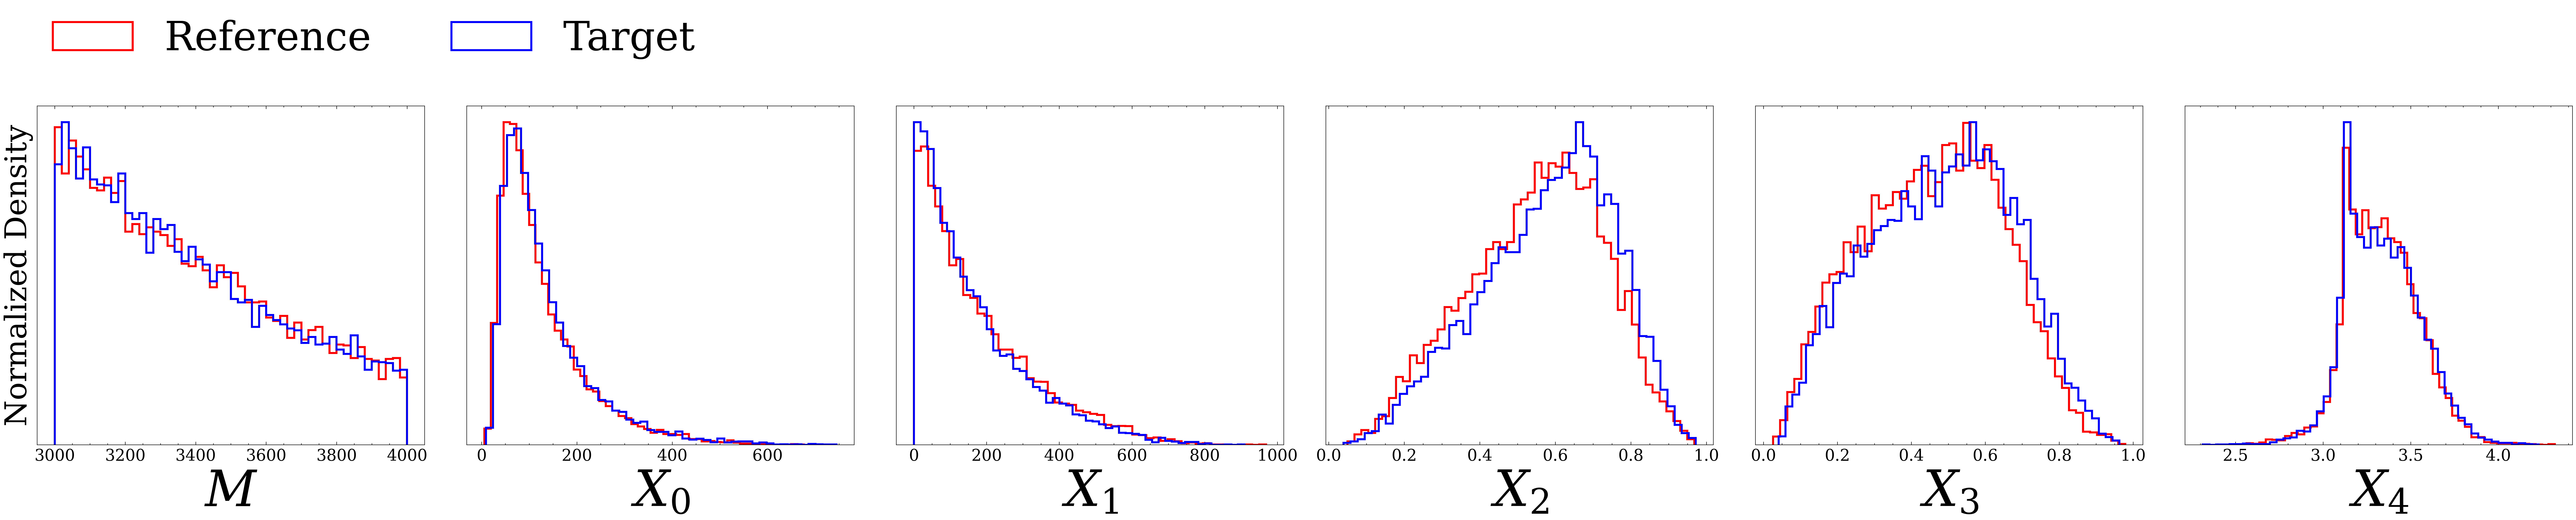

In [9]:
fig, ax = plt.subplots(1, 2, figsize = (12, 4))
fig.subplots_adjust(right=0.8, left = 0.2)

n_plot = 10000

bins = 50




sc_sim = ax[0].scatter(in_range_herwig_bkg[:n_plot,0], in_range_herwig_bkg[:n_plot,1], c = in_range_herwig_bkg[:n_plot,-1], cmap=cm)
ax[0].set_xlabel("F0")
ax[0].set_ylabel("F1")
ax[0].set_title("Sim")

sc_dat = ax[1].scatter(pythia_bkg_w_inj[:n_plot,0], pythia_bkg_w_inj[:n_plot,1], c = pythia_bkg_w_inj[:n_plot,-1], cmap=cm)
ax[1].set_xlabel("F0")
ax[1].set_ylabel("F1")
ax[1].set_title("Dat")

cbar_ax_sim = fig.add_axes([0, 0.15, 0.05, 0.7])
cbar_ax_dat = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(sc_sim, cax=cbar_ax_sim)
fig.colorbar(sc_dat, cax=cbar_ax_dat)

plt.show()




pp = PdfPages(os.path.join("paper_plots", f"LHC_datasets.pdf"))


labels = ["$m_{J_1}$", "$\Delta m_{JJ}$", "$\\tau^{21}_{J_1}$", "$\\tau^{21}_{J_2}$", "$\Delta R_{JJ}$", "$m_{JJ}$"]
labels = ["l","$X_0$", "$X_1$", "$X_2$", "$X_3$", "$X_4$"]
w = 2

fig, ax = plt.subplots(1, n_features, figsize = (6*n_features, 6))

r = ax[0].hist(in_range_herwig_bkg[:n_plot,-1], bins = bins, density = True, label = "Reference", histtype = "step", color = "red", linewidth = w)
t = ax[0].hist(pythia_bkg_w_inj[:n_plot,-1], bins = bins, density = True, label = "Target", histtype = "step", color = "blue", linewidth = w)
#ax[0].legend(fontsize = 30, ncol = 2, loc = (1, 1))
ax[0].set_xlabel("$M$", fontsize = 50)
ax[0].set_ylabel("Normalized Density", fontsize = 30)
ax[0].set_yticks([])






for i in range(1, n_features):
    ax[i].hist(in_range_herwig_bkg[:n_plot,(i-1)], bins = bins, density = True, label = "Reference", histtype = "step", color = "red", linewidth = w)
    ax[i].hist(pythia_bkg_w_inj[:n_plot,(i-1)], bins = bins, density = True, label = "Target", histtype = "step", color = "blue", linewidth = w)
    #ax[i].legend(fontsize = 24)
    ax[i].set_xlabel(labels[i], fontsize = 50)
    ax[i].set_yticks([])
    
plt.tight_layout()

fig.legend(["Reference", "Target"], loc='lower right', bbox_to_anchor=(.285, 1), ncol=len(labels), bbox_transform=fig.transFigure, fontsize = 40)



"""fig, ax = plt.subplots(1, n_features, figsize = (6*n_features, 6))

for i in range(n_features):
    ax[i].hist(trial_data_sim[:n_plot,i], bins = bins, density = True, label = "SIM", histtype = "step", color = "red")
    ax[i].hist(trial_data_dat[:n_plot,i], bins = bins, density = True, label = "DAT", histtype = "step", color = "blue")
    #ax[i].hist(data_injected[:n_plot,i], bins = bins, density = True, label = "SIGNAL", histtype = "step")
    ax[i].legend()
    ax[i].set_ylabel("Density")
    ax[i].set_xlabel(labels[i])
    
plt.tight_layout()
"""
fig.show()


pp.savefig()

pp.close()



In [18]:
# directories
curtains_dir = "/global/home/users/rrmastandrea/CURTAINS_SALAD/"

# function input paramters


dataset_config_string = f"LHCO_{num_signal_to_inject}sig_f/"
data_dir = os.path.join(curtains_dir, dataset_config_string, "data")

print("Making dataset directory at", data_dir, "...")
os.makedirs(data_dir, exist_ok=True)

# prepare the density estimation datasets
sb1_sb2_herwig = pull_from_mass_range(in_range_herwig_bkg, [bands_dict["sb1"], bands_dict["sb2"]])
sb1_sb2_pythia = pull_from_mass_range(pythia_bkg_w_inj, [bands_dict["sb1"], bands_dict["sb2"]])
print(sb1_sb2_herwig.shape,sb1_sb2_pythia.shape )
# split the data into train-val
sim_train, sim_val = train_test_split(sb1_sb2_herwig, test_size=0.2, random_state=42)
dat_train, dat_val = train_test_split(sb1_sb2_pythia, test_size=0.2, random_state=42)


# save

np.save(os.path.join(data_dir, "train_sim.npy"), sim_train)
np.save(os.path.join(data_dir, "val_sim.npy"), sim_val)
np.save(os.path.join(data_dir, "train_dat.npy"), dat_train)
np.save(os.path.join(data_dir, "val_dat.npy"), dat_val)
np.save(os.path.join(data_dir, "col_minmax.npy"), col_minmax)
np.save(os.path.join(data_dir, "col_rescales.npy"), col_rescales)


# prepare the classifier traininf
sr_herwig = pull_from_mass_range(in_range_herwig_bkg, [bands_dict["sr"]])
sr_pythia = pull_from_mass_range(pythia_bkg_w_inj, [bands_dict["sr"]])
print(sr_herwig.shape,sr_pythia.shape )


np.save(os.path.join(data_dir, "classif_train_sim.npy"), sr_herwig)
np.save(os.path.join(data_dir, "classif_train_dat.npy"), sr_pythia)


Making dataset directory at /global/home/users/rrmastandrea/CURTAINS_SALAD/LHCO_0sig_f/data ...
(124814, 6) (124562, 6)
(60739, 6) (60038, 6)


In [ ]:
# Plot specific bands

In [ ]:

band = "sr"



trial_data_sim = pull_from_mass_range(data_sim, [bands_dict[band]])
trial_data_dat = pull_from_mass_range(data_dat, [bands_dict[band]])

print(trial_data_sim.shape)
print(trial_data_dat.shape)

print(f"SIM {band} shape:", trial_data_sim.shape)
print(f"DAT {band} shape:", trial_data_dat.shape)

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
fig.subplots_adjust(right=0.8)

sc_sim = ax[0].scatter(trial_data_sim[:,0], trial_data_sim[:,1], c = trial_data_sim[:,-1], cmap=cm)
ax[0].set_xlabel("F0")
ax[0].set_ylabel("F1")
ax[0].set_title("Sim")

sc_dat = ax[1].scatter(trial_data_dat[:,0], trial_data_dat[:,1], c = trial_data_dat[:,-1], cmap=cm)
ax[1].set_xlabel("F0")
ax[1].set_ylabel("F1")
ax[1].set_title("Dat")

cbar_ax_sim = fig.add_axes([0, 0.15, 0.05, 0.7])
cbar_ax_dat = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(sc_sim, cax=cbar_ax_sim)
fig.colorbar(sc_dat, cax=cbar_ax_dat)

plt.show()


fig, ax = plt.subplots(1, n_features, figsize = (4*n_features, 4))
for i in range(n_features):
    ax[i].hist(trial_data_sim[:,i], density = True, label = "p_1", histtype = "step")
    ax[i].hist(trial_data_dat[:,i], density = True, label = "p_2", histtype = "step")
    ax[i].legend()
    ax[i].set_title(f"f{i}")

fig.show()




In [ ]:
# pull sb1, sb2


trial_data_sim_mms = minmaxscale(trial_data_sim, col_minmax)
trial_data_dat_mms = minmaxscale(trial_data_dat, col_minmax)



fig, ax = plt.subplots(1, 2, figsize = (8, 4))
fig.subplots_adjust(right=0.8)

sc_sim = ax[0].scatter(trial_data_sim_mms[:,0], trial_data_sim_mms[:,1], c = trial_data_sim_mms[:,-1], cmap=cm)
ax[0].set_xlabel("F0")
ax[0].set_ylabel("F1")
ax[0].set_title("Sim")

sc_dat = ax[1].scatter(trial_data_dat_mms[:,0], trial_data_dat_mms[:,1], c = trial_data_dat_mms[:,-1], cmap=cm)
ax[1].set_xlabel("F0")
ax[1].set_ylabel("F1")
ax[1].set_title("Dat")

cbar_ax_sim = fig.add_axes([0, 0.15, 0.05, 0.7])
cbar_ax_dat = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(sc_sim, cax=cbar_ax_sim)
fig.colorbar(sc_dat, cax=cbar_ax_dat)

plt.show()


fig, ax = plt.subplots(1, n_features, figsize = (4*n_features, 4))
for i in range(n_features):
    ax[i].hist(trial_data_sim_mms[:,i], density = True, label = "p_1", histtype = "step")
    ax[i].hist(trial_data_dat_mms[:,i], density = True, label = "p_2", histtype = "step")
    ax[i].legend()
    ax[i].set_yscale("log")
    ax[i].set_title(f"f{i}")

fig.show()



